In [13]:
import numpy as np
from scipy.spatial.transform import Rotation as R

pose_dict = {}

with open("gt_pose.txt", "r") as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()
    if line:
        # Parse timestamp
        timestamp_str, _ = line.split(" ", 1)
        timestamp = float(timestamp_str)

        # Parse 4x4 matrix over next 4 lines
        matrix_lines = []
        line = line[line.find('[[')+1:]  # First line: strip before first [
        for j in range(4):
            if j > 0:
                i += 1
                line = lines[i].strip()
            row = list(map(float, line.replace('[', '').replace(']', '').split()))
            matrix_lines.append(row)

        pose_dict[timestamp] = np.array(matrix_lines)
    i += 1

# Convert to trajectory
trajectory_list = []
for ts, T in pose_dict.items():
    R_mat = T[:3, :3]
    t_vec = T[:3, 3]
    quat = R.from_matrix(R_mat).as_quat()  # [qx, qy, qz, qw]
    trajectory_list.append([ts, *t_vec, *quat])

# Save
with open("trajectory.txt", "w") as f:
    # Write header annotation for each column
    f.write("# timestamp tx ty tz qx qy qz qw\n")
    for row in sorted(trajectory_list):
        f.write("{:.4f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f}\n".format(*row))


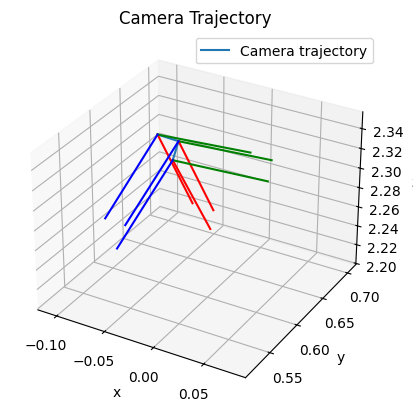

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Load trajectory
data = np.loadtxt('trajectory.txt')

# Extract positions and quaternions
positions = data[:, 1:4]
quaternions = data[:, 4:8]

# Optional: Plot camera orientations as well
def plot_camera(ax, position, quaternion, scale=0.1):
    r = R.from_quat(quaternion)
    rot_matrix = r.as_matrix()
    origin = position
    x_axis = origin + scale * rot_matrix[:, 0]
    y_axis = origin + scale * rot_matrix[:, 1]
    z_axis = origin + scale * rot_matrix[:, 2]
    ax.plot([origin[0], x_axis[0]], [origin[1], x_axis[1]], [origin[2], x_axis[2]], 'r')
    ax.plot([origin[0], y_axis[0]], [origin[1], y_axis[1]], [origin[2], y_axis[2]], 'g')
    ax.plot([origin[0], z_axis[0]], [origin[1], z_axis[1]], [origin[2], z_axis[2]], 'b')

# Plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Camera trajectory')

# Optional: plot every N-th camera orientation
for i in range(0, len(positions)):
    plot_camera(ax, positions[i], quaternions[i])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
ax.set_title('Camera Trajectory')
ax.axis('equal')
plt.show()
